### Extract section across Atlantic

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
import scipy.stats as st

import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## functions

In [3]:
### function to fix non-monotonic longitude
def fix_orca_longitude(input_lon):
    j_step, i_step = np.where(np.diff(input_lon, axis=1) < 0)
    
    output_lon = input_lon.copy()
    
    for j,i in zip(j_step,i_step):
        output_lon[j, i+1:] = (input_lon[j, i+1:].values + 360)
        
    return output_lon - 360

def find_i_j(lon, lat, LON, LAT):
    '''  get indices of (lon, lat) point on NEMO grid (LON,LAT)
         lon, lat: Point to get the indice
         LON, LAT: NEMO nav_lon, nav_lat '''
    a = abs(LAT - lat) + abs(LON - lon)
    j, i = np.unravel_index(a.argmin(), a.shape)
    return j, i

## load data

In [4]:
## mask 
path_mask = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/'
mesh_mask = xr.open_dataset(path_mask + 'mesh_mask.nc').squeeze()

In [21]:
lon = mesh_mask.nav_lon
lat = mesh_mask.nav_lat
dpt = mesh_mask.nav_lev

In [10]:
## MHW stats
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/ANALYSIS/'

ds_R  = xr.open_mfdataset(path+'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_Duration-WMO-*.nc', combine='nested', concat_dim='deptht')
ds_E  = xr.open_mfdataset(path+'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_Events-WMO-*.nc', combine='nested', concat_dim='deptht')
ds_I  = xr.open_mfdataset(path+'VIKING20X.L46-KFS003-6th_1y_19800101_20221231_IntensityMax-WMO-*.nc', combine='nested', concat_dim='deptht')

## define section

In [11]:
## section end points on model grid
jj,ii = find_i_j(-45,65,lon,lat)
j0,i0 = find_i_j(-45,55,lon,lat)
j1,i1 = find_i_j(-70,55,lon,lat)
j2,i2 = find_i_j(-70,19,lon,lat)
j3,i3 = find_i_j(0,19,lon,lat)
j4,i4 = find_i_j(0,-34,lon,lat)

In [12]:
## define section segments
y_sec = np.arange(j1,jj); x_sec = i0
y_sec0 = j1; x_sec0 = np.arange(i2,i0)
y_sec1 = np.arange(j2,j1); x_sec1 = i2
y_sec2 = j2; x_sec2 = np.arange(i2,i3)
y_sec3 = np.arange(j4,j3); x_sec3 = i3

In [13]:
## geographical x-axis
lons  = lon.isel(x=x_sec, y=y_sec); lats  = lat.isel(x=x_sec, y=y_sec)
lons0 = lon.isel(x=x_sec0, y=y_sec0); lats0 = lat.isel(x=x_sec0, y=y_sec0)
lons1 = lon.isel(x=x_sec1, y=y_sec1); lats1 = lat.isel(x=x_sec1, y=y_sec1)
lons2 = lon.isel(x=x_sec2, y=y_sec2); lats2 = lat.isel(x=x_sec2, y=y_sec2)
lons3 = lon.isel(x=x_sec3, y=y_sec3); lats3 = lat.isel(x=x_sec3, y=y_sec3)

lons_sec = xr.concat([lons3.rename({'y':'c'}), 
                        lons2.rename({'x':'c'})[::-1],
                        lons1.rename({'y':'c'}),
                        lons0.rename({'x':'c'}),
                        lons.rename({'y':'c'}),
                    ], dim='c') 

lats_sec = xr.concat([lats3.rename({'y':'c'}), 
                        lats2.rename({'x':'c'})[::-1],
                        lats1.rename({'y':'c'}),
                        lats0.rename({'x':'c'}),
                        lats.rename({'y':'c'}),
                    ], dim='c') 

## MHWs stats and EKE,MKE along sections

In [14]:
Dur_SEC = xr.concat([ds_R.isel(y=y_sec3,x=x_sec3-750).Duration_mn.rename({'y':'c'}), 
                     ds_R.isel(y=y_sec2,x=x_sec2-750).Duration_mn.rename({'x':'c'})[:,:,::-1],
                     ds_R.isel(y=y_sec1,x=x_sec1-750).Duration_mn.rename({'y':'c'}),
                     ds_R.isel(y=y_sec0,x=x_sec0-750).Duration_mn.rename({'x':'c'}),
                     ds_R.isel(y=y_sec,x=x_sec-750).Duration_mn.rename({'y':'c'}),
                     ], dim='c')

Dur_sec = Dur_SEC.mean('time').compute()
Dur_sec = Dur_sec.where(Dur_sec>0)

## linear trend 
Dur_SEC = Dur_SEC.fillna(0).values

lin_reg_D = np.zeros((2,46,860))
for zz in range(0,46):
    print(zz, end=' ')
    for cc in range(0,860):
        lin_reg_D[:,zz,cc] = st.linregress(np.arange(1980,2023), Dur_SEC[zz,:,cc])[0:4:3]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 

In [15]:
Fre_SEC = xr.concat([ds_E.isel(y=y_sec3,x=x_sec3-750).N_events.rename({'y':'c'}), 
                     ds_E.isel(y=y_sec2,x=x_sec2-750).N_events.rename({'x':'c'})[:,:,::-1],
                     ds_E.isel(y=y_sec1,x=x_sec1-750).N_events.rename({'y':'c'}),
                     ds_E.isel(y=y_sec0,x=x_sec0-750).N_events.rename({'x':'c'}),
                     ds_E.isel(y=y_sec,x=x_sec-750).N_events.rename({'y':'c'}),
                     ], dim='c')

Fre_sec = Fre_SEC.mean('time').compute()
Fre_sec = Fre_sec.where(Fre_sec>0)

## linear trend 
Fre_SEC = Fre_SEC.fillna(0).values

lin_reg_F = np.zeros((2,46,860))
for zz in range(0,46):
    print(zz, end=' ')
    for cc in range(0,860):
        lin_reg_F[:,zz,cc] = st.linregress(np.arange(1980,2023), Fre_SEC[zz,:,cc])[0:4:3]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 

In [16]:
Int_SEC = xr.concat([ds_I.isel(y=y_sec3,x=x_sec3-750).Intensity_max_mn.rename({'y':'c'}), 
                     ds_I.isel(y=y_sec2,x=x_sec2-750).Intensity_max_mn.rename({'x':'c'})[:,:,::-1],
                     ds_I.isel(y=y_sec1,x=x_sec1-750).Intensity_max_mn.rename({'y':'c'}),
                     ds_I.isel(y=y_sec0,x=x_sec0-750).Intensity_max_mn.rename({'x':'c'}),
                     ds_I.isel(y=y_sec,x=x_sec-750).Intensity_max_mn.rename({'y':'c'}),                     
                     ], dim='c')

Int_sec = Int_SEC.mean('time').compute()
Int_sec = Int_sec.where(Int_sec>0)

## linear trend 
Int_SEC = Int_SEC.fillna(0).values

lin_reg_I = np.zeros((2,46,860))
for zz in range(0,46):
    print(zz, end=' ')
    for cc in range(0,860):
        lin_reg_I[:,zz,cc] = st.linregress(np.arange(1980,2023), Int_SEC[zz,:,cc])[0:4:3]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 

In [17]:
land_sec = xr.concat([mesh_mask.isel(y=y_sec3,x=x_sec3).tmask.rename({'y':'c'}), 
                      mesh_mask.isel(y=y_sec2,x=x_sec2).tmask.rename({'x':'c'})[:,::-1],
                      mesh_mask.isel(y=y_sec1,x=x_sec1).tmask.rename({'y':'c'}),
                      mesh_mask.isel(y=y_sec0,x=x_sec0).tmask.rename({'x':'c'}),
                      mesh_mask.isel(y=y_sec,x=x_sec).tmask.rename({'y':'c'}),
                     ], dim='c')
land_sec = land_sec.where(land_sec==0)

## plotting

In [18]:
lc = len(land_sec.c) ## number of section points

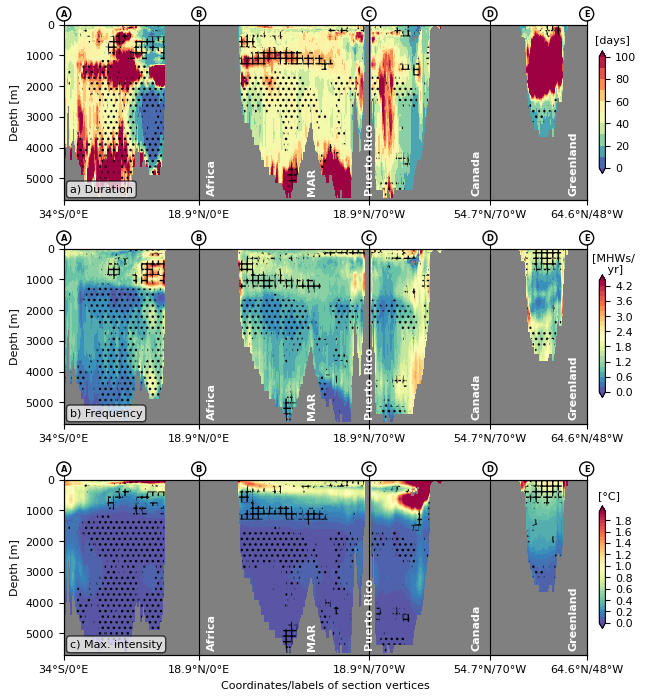

In [46]:
fig = plt.figure(figsize=(7.,7))

ax1 = fig.add_axes([0.08,0.71,0.9,0.25]); ax2 = fig.add_axes([0.08,0.39,0.9,0.25]);  ax3 = fig.add_axes([0.08,0.06,0.9,0.25])

### MHW stats
##
ax1.contourf(np.arange(0,lc), -dpt, np.zeros(land_sec.shape), colors='grey')
ctf1 = ax1.contourf(np.arange(0,lc), -dpt, Dur_sec, cmap='Spectral_r', levels=np.arange(0,110,10), extend='both')
ax1.set_yticks(np.arange(-5000,1,1000)); ax1.set_yticklabels(np.arange(5000,-1,-1000))
ax1.text(235, -5500,  'Africa', color='w', fontsize=8, rotation=90, fontweight='bold')
ax1.text(400, -5500,  'MAR', color='w', fontsize=8, rotation=90, fontweight='bold')
ax1.text(495, -5500,  'Puerto Rico', color='w', fontsize=8, rotation=90, fontweight='bold')
ax1.text(670, -5500,  'Canada', color='w', fontsize=8, rotation=90, fontweight='bold')
ax1.text(830, -5500,  'Greenland', color='w', fontsize=8, rotation=90, fontweight='bold')
ax1.set_ylabel('Depth [m]', fontsize=8)
ax1.set_xlim(0,lc)
ax1.set_ylim(-5700,0)

plt.rcParams['hatch.color'] = 'k'
ax1.contourf(np.arange(0,lc), -dpt, np.ma.masked_equal((lin_reg_D[1,:,:]<0.01) & (lin_reg_D[0,:,:]<0) ,0),hatches=['...'], colors='none')
plt.rcParams['hatch.color'] = 'k'
ax1.contourf(np.arange(0,lc), -dpt, np.ma.masked_equal((lin_reg_D[1,:,:]<0.01) & (lin_reg_D[0,:,:]>0) ,0),hatches=['+++'], colors='none')

ax1.vlines(222, 0, -5700, color='k', lw=0.8)
ax1.vlines(502, 0, -5700, color='k', lw=0.8)
ax1.vlines(701, 0, -5700, color='k', lw=0.8)

ax1.set_xticks([0,222,502,701,lc])
ax1.set_xticklabels(['34°S/0°E','18.9°N/0°E','18.9°N/70°W', '54.7°N/70°W','64.6°N/48°W']);

ax1.text(10,-5460,'a) Duration', fontsize=8, bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))

ax11 = ax1.twiny()
ax11.set_xlim(0,lc)
ax11.set_xticks([0,222,502,701,lc])
ax11.set_xticklabels(['A','B','C', 'D','E'], fontsize=8);
ax11.tick_params(axis='both', which='major', pad=1)
for label in ax11.get_xticklabels():
    label.set_bbox(dict(boxstyle='circle', facecolor='none', edgecolor='k'))
    label.set_fontsize(6)
    label.set_fontweight('bold')

##
ax2.contourf(np.arange(0,lc), -dpt, np.zeros(land_sec.shape), colors='grey')
ctf2 = ax2.contourf(np.arange(0,lc), -dpt, Fre_sec, cmap='Spectral_r', levels=np.arange(0,4.6,0.2), extend='both')
ax2.set_yticks(np.arange(-5000,1,1000)); ax2.set_yticklabels(np.arange(5000,-1,-1000))
ax2.text(235, -5500,  'Africa', color='w', fontsize=8, rotation=90, fontweight='bold')
ax2.text(400, -5500,  'MAR', color='w', fontsize=8, rotation=90, fontweight='bold')
ax2.text(495, -5500,  'Puerto Rico', color='w', fontsize=8, rotation=90, fontweight='bold')
ax2.text(670, -5500,  'Canada', color='w', fontsize=8, rotation=90, fontweight='bold')
ax2.text(830, -5500,  'Greenland', color='w', fontsize=8, rotation=90, fontweight='bold')
ax2.set_ylabel('Depth [m]', fontsize=8)
ax2.set_xlim(0,lc)
ax2.set_ylim(-5700,0)

plt.rcParams['hatch.color'] = 'k'
ax2.contourf(np.arange(0,lc), -dpt, np.ma.masked_equal((lin_reg_F[1,:,:]<0.01) & (lin_reg_F[0,:,:]<0) ,0),hatches=['...'], colors='none')
plt.rcParams['hatch.color'] = 'k'
ax2.contourf(np.arange(0,lc), -dpt, np.ma.masked_equal((lin_reg_F[1,:,:]<0.01) & (lin_reg_F[0,:,:]>0) ,0),hatches=['+++'], colors='none')

ax2.vlines(222, 0, -5700, color='k', lw=0.8)
ax2.vlines(502, 0, -5700, color='k', lw=0.8)
ax2.vlines(701, 0, -5700, color='k', lw=0.8)

ax2.set_xticks([0,222,502,701,lc])
ax2.set_xticklabels(['34°S/0°E','18.9°N/0°E','18.9°N/70°W', '54.7°N/70°W','64.6°N/48°W']);
ax2.text(10,-5460,'b) Frequency', fontsize=8, bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))

ax21 = ax2.twiny()
ax21.set_xlim(0,lc)
ax21.set_xticks([0,222,502,701,lc])
ax21.set_xticklabels(['A','B','C', 'D','E'], fontsize=8);
ax21.tick_params(axis='both', which='major', pad=1)
for label in ax21.get_xticklabels():
    label.set_bbox(dict(boxstyle='circle', facecolor='none', edgecolor='k'))
    label.set_fontsize(6)
    label.set_fontweight('bold')

##
ax3.contourf(np.arange(0,lc), -dpt, np.zeros(land_sec.shape), colors='grey')
ctf3 = ax3.contourf(np.arange(0,lc), -dpt, Int_sec, cmap='Spectral_r', levels=np.arange(0,2,0.05), extend='both')
ax3.set_yticks(np.arange(-5000,1,1000)); ax3.set_yticklabels(np.arange(5000,-1,-1000))
ax3.text(235, -5500,  'Africa', color='w', fontsize=8, rotation=90, fontweight='bold')
ax3.text(400, -5500,  'MAR', color='w', fontsize=8, rotation=90, fontweight='bold')
ax3.text(495, -5500,  'Puerto Rico', color='w', fontsize=8, rotation=90, fontweight='bold')
ax3.text(670, -5500,  'Canada', color='w', fontsize=8, rotation=90, fontweight='bold')
ax3.text(830, -5500,  'Greenland', color='w', fontsize=8, rotation=90, fontweight='bold')
ax3.set_ylabel('Depth [m]', fontsize=8)
ax3.set_xlabel('Coordinates/labels of section vertices', fontsize=8)
ax3.set_xlim(0,lc)
ax3.set_ylim(-5700,0)

plt.rcParams['hatch.color'] = 'k'
ax3.contourf(np.arange(0,lc), -dpt, np.ma.masked_equal((lin_reg_I[1,:,:]<0.01) & (lin_reg_I[0,:,:]<0) ,0),hatches=['...'], colors='none')
plt.rcParams['hatch.color'] = 'k'
ax3.contourf(np.arange(0,lc), -dpt, np.ma.masked_equal((lin_reg_I[1,:,:]<0.01) & (lin_reg_I[0,:,:]>0) ,0),hatches=['+++'], colors='none')
ax3.vlines(222, 0, -5700, color='k', lw=0.8)
ax3.vlines(502, 0, -5700, color='k', lw=0.8)
ax3.vlines(701, 0, -5700, color='k', lw=0.8)

ax3.set_xticks([0,222,502,701,lc])
ax3.set_xticklabels(['34°S/0°E','18.9°N/0°E','18.9°N/70°W', '54.7°N/70°W','64.6°N/48°W']);

ax3.text(10,-5460,'c) Max. intensity', fontsize=8, bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))

ax31 = ax3.twiny()
ax31.set_xlim(0,lc)
ax31.set_xticks([0,222,502,701,lc])
ax31.set_xticklabels(['A','B','C', 'D','E'], fontsize=8);
ax31.tick_params(axis='both', which='major', pad=1)
for label in ax31.get_xticklabels():
    label.set_bbox(dict(boxstyle='circle', facecolor='none', edgecolor='k'))
    label.set_fontsize(6)
    label.set_fontweight('bold')

#### coloarbars
cb1 = plt.colorbar(ctf1, ax=ax1, orientation='vertical', shrink=0.7, pad=0.02)
cb1.set_label('[days]', fontsize=8, y=1.19, labelpad=-17, rotation=0)
cb2 = plt.colorbar(ctf2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)
cb2.set_label('[MHWs/\n yr]', fontsize=8, y=1.25, labelpad=-14, rotation=0)
cb3 = plt.colorbar(ctf3, ax=ax3, orientation='vertical', shrink=0.7, pad=0.02)
cb3.set_label('[°C]', fontsize=8, y=1.19, labelpad=-17, rotation=0)

plt.savefig('MHW_sections.png', dpi=400)

## save data for publication


In [41]:
Dur_sec.attrs['long_name'] = 'Mean marine heatwave duration along Atlantic section'
Dur_sec.attrs['units'] = 'days'

Fre_sec.attrs['long_name'] = 'Mean marine heatwave frequency along Atlantic section'
Fre_sec.attrs['units'] = 'MHWs/yr'

Int_sec.attrs['long_name'] = 'Mean marine heatwave maximum intensity along Atlantic section'
Int_sec.attrs['units'] = 'degC'

In [42]:
lin_reg_I_xr = xr.DataArray(lin_reg_I).rename({'dim_0':'coef','dim_1':'deptht', 'dim_2':'c'})
lin_reg_I_xr.attrs['long_name'] = 'Linear regression coefficients (slope and p-value) for maximum intensity'
lin_reg_I_xr.attrs['units'] = '°C/yr'

lin_reg_D_xr = xr.DataArray(lin_reg_D).rename({'dim_0':'coef','dim_1':'deptht', 'dim_2':'c'})
lin_reg_D_xr.attrs['long_name'] = 'Linear regression coefficients (slope and p-value) for duration'
lin_reg_D_xr.attrs['units'] = 'days/yr'

lin_reg_F_xr = xr.DataArray(lin_reg_F).rename({'dim_0':'coef','dim_1':'deptht', 'dim_2':'c'})
lin_reg_F_xr.attrs['long_name'] = 'Linear regression coefficients (slope and p-value) for frequency'
lin_reg_F_xr.attrs['units'] = 'MHWs/yr/yr'


In [43]:
ds_out = xr.Dataset(data_vars={'Dur_sec':Dur_sec, 'Fre_sec': Fre_sec, 'Int_sec':Int_sec, 
                               'lin_reg_I':lin_reg_I_xr, 'lin_reg_D':lin_reg_D_xr, 'lin_reg_F':lin_reg_F_xr,
                               'deptht':ds.deptht})

In [44]:
## set global attributes
ds_out.attrs['title'] = 'MHW characteristics along Atlantic section'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 5_Sections.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-01-16'
ds_out.attrs['date_modified'] = '2025-01-16'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [45]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure05.nc')